In [1]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, recall_score, confusion_matrix

from mypackage import dir

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Environment variables
project = 'france'
data = dir.make_dir(project) 
raw = data('raw')
processed = data('processed')
models = data('models')
outputs = data('outputs')

smote = SMOTE(random_state=42)

# Función para cargar datos
def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

def almacenar_en_db(df: pd.DataFrame, table_name: str) -> None:
    df.to_parquet(outputs/f'{table_name}.parquet.gzip', compression='gzip')
    print(f'Saved table: {table_name}')


In [3]:
# Identificar columnas
numeric_features = ['edad','dias','transaccion',]
categorical_features = ['agencia_origen', 'linea', 'agencia_destino', 'tipo_cliente', 'codigo_actividad', 
                        'sexo', 'estrato', 'tipo_identificacion', 'estudios', 'canal', 'medio_transaccion', 
                        'tipo_entidad']

In [4]:
df = cargar_datos('dataset_train')
df['agencia_origen'] = df['agencia_origen'].astype(int)
df['agencia_destino'] = df['agencia_destino'].astype(int)
df['codigo_actividad'] = df['codigo_actividad'].astype(int)
df['estrato'] = df['estrato'].astype(int)

# df[categorical_features] = df[categorical_features].astype(str)

df.head()

Loaded table: dataset_train


,agencia_origen,linea,agencia_destino,tipo_cliente,codigo_actividad,sexo,edad,estrato,tipo_identificacion,estudios,canal,medio_transaccion,dias,transaccion,tipo_entidad
80494,14,1,14,4,161,2,55,1,1,5,0,1,2371,1000000,1
66983,5,6,5,4,1410,1,38,2,1,6,0,1,2723,5000000,1
18497,13,7,13,1,10,2,25,2,1,6,0,1,2901,950000,1
26734,7,11,7,4,7420,2,35,2,1,1,0,1,2365,3000000,1
39296,4,11,4,1,10,2,19,2,1,5,0,1,2544,1000000,1


In [5]:
X = df.copy()

In [6]:
# Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ("minmax", MinMaxScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocesar los datos
X_preprocessed = preprocessor.fit_transform(X)

In [7]:
# Definir los modelos
iso_model = IsolationForest(contamination=0.1)
svm_model = OneClassSVM(gamma='auto', nu=0.1)
elliptic_model = EllipticEnvelope(contamination=0.1)

# Ajustar los modelos
iso_model.fit(X_preprocessed)
svm_model.fit(X_preprocessed)
elliptic_predictions = elliptic_model.fit_predict(X_preprocessed.toarray())

# Predecir con cada modelo
iso_predictions = iso_model.predict(X_preprocessed)
svm_predictions = svm_model.predict(X_preprocessed)

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [8]:
# Crear un DataFrame con las predicciones de los tres modelos
results = pd.DataFrame({
    'IsolationForest': iso_predictions,
    'OneClassSVM': svm_predictions,
    'EllipticEnvelope': elliptic_predictions,
})
# Combinar las predicciones por votación mayoritaria
results['combined_predictions'] = np.sign(results.sum(axis=1))
results.head()

,IsolationForest,OneClassSVM,EllipticEnvelope,combined_predictions
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,-1,1
4,1,1,1,1


In [9]:
# df['IsolationForest'] = None
# df['OneClassSVM'] = None
# df['EllipticEnvelope'] = None
# df.loc[X_train.index, 'IsolationForest'] = iso_predictions
# df.loc[X_train.index, 'OneClassSVM'] = svm_predictions
# df.loc[X_train.index, 'EllipticEnvelope'] = elliptic_predictions
df['combined_predictions'] = None
df.loc[X.index, 'combined_predictions'] = list(results['combined_predictions'])

In [10]:
almacenar_en_db(df, 'output_no_supervisado')

Saved table: output_no_supervisado


## Modelo supervisado

In [44]:
df['combined_predictions'] = df['combined_predictions'].astype(int)
X = df.drop(['combined_predictions'], axis=1)
y = df['combined_predictions']
# X, y = smote.fit_resample(X, y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Crear transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ("minmax", MinMaxScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

In [47]:
# Entrenar modelo
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['edad', 'dias',
                                                   'transaccion']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['agencia_origen', 'linea',
                                                   'agencia_destino',
                                                   'tipo_cliente',
                                                   'codigo_actividad', 'sexo',
                                                   'estrato',
                                                   'tipo_identificacion',
                                                   'estudios', 'canal',
                                                   'medio_transaccion',
                                                   'tipo_entidad'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [48]:
y_pred = clf.predict(X_test)
recall_score(y_test, y_pred, average='weighted')

0.9743119266055046

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.71      0.77        99
           1       0.98      0.99      0.99      1536

    accuracy                           0.97      1635
   macro avg       0.91      0.85      0.88      1635
weighted avg       0.97      0.97      0.97      1635



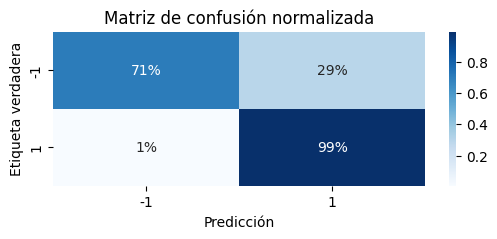

In [50]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ['-1', '1']

fig, axs = plt.subplots(figsize=(6, 2))
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

## Conjunto nuevo de datos

In [51]:
df_val = cargar_datos('dataset_val')
df_val = df_val.sample(frac=0.1)
df_val['pred'] = clf.predict(df_val)
almacenar_en_db(df_val, 'bank')
df_val.head()

Loaded table: dataset_val
Saved table: bank


,agencia_origen,linea,agencia_destino,tipo_cliente,codigo_actividad,sexo,edad,estrato,tipo_identificacion,estudios,canal,medio_transaccion,dias,transaccion,tipo_entidad,pred
72387,4,6,4,1,10,1,31,3,1,8,0,1,2340,1662810,1,1
77303,3,11,3,4,8890,2,42,3,1,7,0,1,2376,1706000,1,1
51248,13,7,13,4,5813,1,26,3,1,8,2,1,2894,2800000,1,-1
64707,1,13,1,4,6810,1,71,3,1,5,3,1,2470,2260408,1,-1
55091,4,11,4,1,10,2,23,1,1,6,0,1,3466,644350,1,1


In [52]:
df_val['pred'].value_counts()

pred
 1    6080
-1    1277
Name: count, dtype: int64

In [53]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7357 entries, 72387 to 23312
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   agencia_origen       7357 non-null   object
 1   linea                7357 non-null   int32 
 2   agencia_destino      7357 non-null   object
 3   tipo_cliente         7357 non-null   int32 
 4   codigo_actividad     7357 non-null   object
 5   sexo                 7357 non-null   int32 
 6   edad                 7357 non-null   int64 
 7   estrato              7357 non-null   object
 8   tipo_identificacion  7357 non-null   int32 
 9   estudios             7357 non-null   int32 
 10  canal                7357 non-null   int32 
 11  medio_transaccion    7357 non-null   int32 
 12  dias                 7357 non-null   int64 
 13  transaccion          7357 non-null   int64 
 14  tipo_entidad         7357 non-null   int32 
 15  pred                 7357 non-null   int32 
dtypes: int

In [54]:
new_data = pd.DataFrame({
    'agencia_origen': [1],  
    'linea': [2],  
    'agencia_destino': [1],  
    'tipo_cliente': [3],
    'codigo_actividad': [100],
    'sexo': [1],
    'edad': [44],
    'estrato': [3],
    'tipo_identificacion': [1],
    'estudios': [1],
    'canal': [1],
    'medio_transaccion': [1],
    'dias': [1],
    'transaccion':[123999],
    'tipo_entidad':[1],
})
print(f'La predicción de este nuevo dato: {clf.predict(new_data)}')

La predicción de este nuevo dato: [-1]


In [55]:
logistic_regression_coefficients = clf.named_steps['classifier'].coef_
# Obtener los nombres de las características transformadas
numeric_feature_names = numeric_features
categorical_feature_names = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combinar los nombres de las características
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Crear un DataFrame para visualizar los coeficientes
coefficients_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': logistic_regression_coefficients[0]  
})

# Ordenar por valor absoluto de los coeficientes para ver las características más importantes
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

coefficients_df.head()

,Feature,Coefficient,Absolute_Coefficient
300,canal_0,4.551550,4.551550
304,medio_transaccion_0,-3.737146,3.737146
2,transaccion,-3.487188,3.487188
305,medio_transaccion_1,3.483748,3.483748
287,tipo_identificacion_1,3.050484,3.050484


In [56]:
fig = px.histogram(df_val, x="canal", color="pred")
fig.show()

## TSNE

In [57]:
X_train.head()

,agencia_origen,linea,agencia_destino,tipo_cliente,codigo_actividad,sexo,edad,estrato,tipo_identificacion,estudios,canal,medio_transaccion,dias,transaccion,tipo_entidad
45749,1,11,1,1,10,1,46,3,1,1,3,1,2338,2636326,1
44803,17,7,17,1,10,2,34,3,1,7,0,1,2633,946717,1
19067,18,1,4,4,5611,1,47,2,1,6,0,1,2536,916666,1
5629,3,1,3,3,82,1,23,1,1,6,0,1,2442,100000,1
6492,2,1,2,2,82,2,10,1,4,4,0,1,2571,30000,1


In [58]:
transformaciones = clf.named_steps['preprocessor']
datos_transformados = transformaciones.transform(X_train)

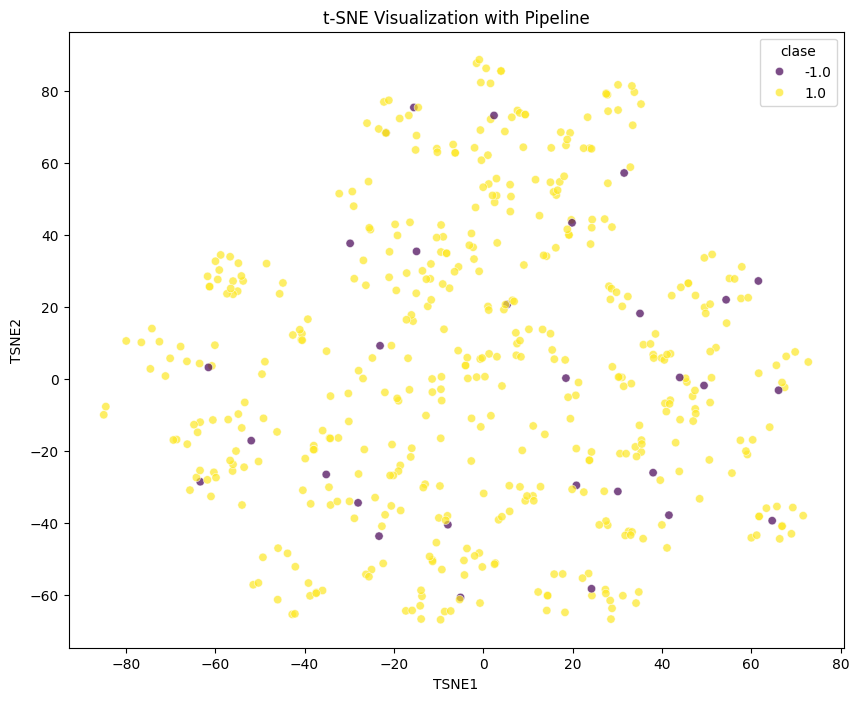

In [59]:
# Aplicar t-SNE a los datos transformados
tsne = TSNE(n_components=2, init="random", random_state=42)
tsne_resultados = tsne.fit_transform(datos_transformados)

# Crear un DataFrame con los resultados de t-SNE y la clase
tsne_df = pd.DataFrame(data=tsne_resultados, columns=['TSNE1', 'TSNE2'])
tsne_df['clase'] = y_train

# Visualizar los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='clase', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization with Pipeline')
plt.show()

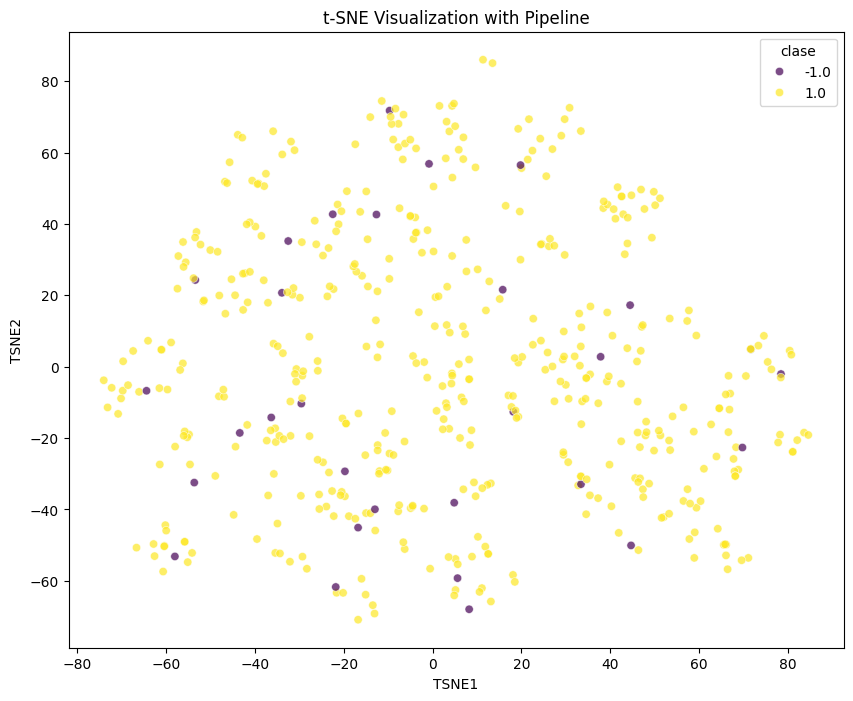

In [60]:
# Aplicar t-SNE a los datos transformados
tsne = TSNE(n_components=2, random_state=42)
tsne_resultados = tsne.fit_transform(datos_transformados.toarray())

# Crear un DataFrame con los resultados de t-SNE y la clase
tsne_df = pd.DataFrame(data=tsne_resultados, columns=['TSNE1', 'TSNE2'])
tsne_df['clase'] = y_train

# Visualizar los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='clase', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization with Pipeline')
plt.show()

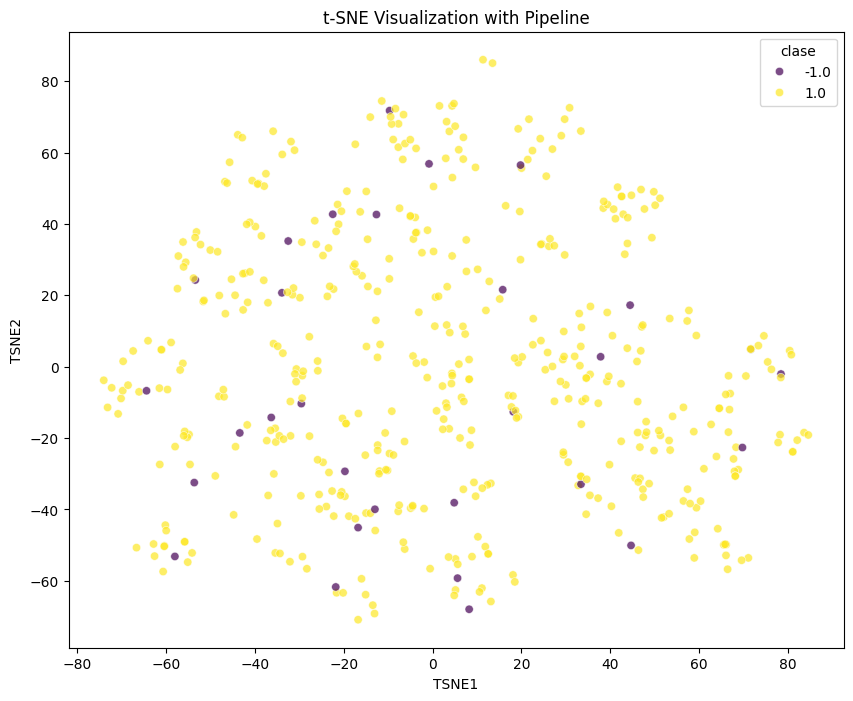

In [61]:
# Aplicar t-SNE a los datos transformados
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_resultados = tsne.fit_transform(datos_transformados.toarray())

# Crear un DataFrame con los resultados de t-SNE y la clase
tsne_df = pd.DataFrame(data=tsne_resultados, columns=['TSNE1', 'TSNE2'])
tsne_df['clase'] = y_train

# Visualizar los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='clase', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization with Pipeline')
plt.show()

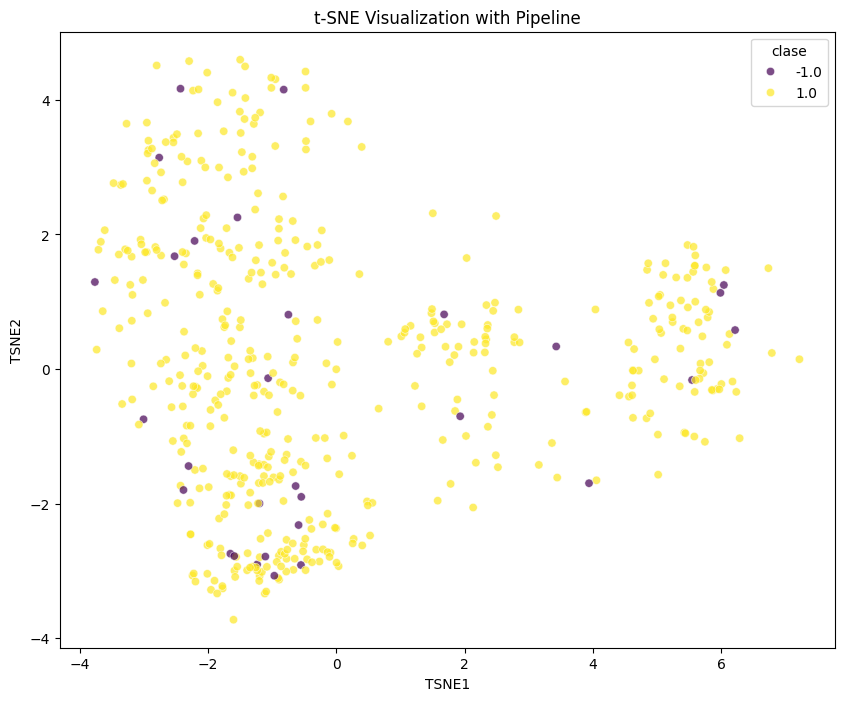

In [62]:
isomap = Isomap(
    n_neighbors=30,
    n_components=2,
    path_method="auto",
    neighbors_algorithm="auto",
)

X_projected = isomap.fit_transform(datos_transformados)

# Crear un DataFrame con los resultados de t-SNE y la clase
tsne_df = pd.DataFrame(data=X_projected, columns=['TSNE1', 'TSNE2'])
tsne_df['clase'] = y_train

# Visualizar los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='clase', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization with Pipeline')
plt.show()

## Guardar modelo

In [63]:
X = df.drop(['combined_predictions'], axis=1)
y = df['combined_predictions']
# X, y = smote.fit_resample(X, y)

In [64]:
# Estandarización
scaler = MinMaxScaler()
scaler2 = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])
X_scaled = scaler2.fit_transform(X_scaled)

# Codificación One-hot
encoder = OneHotEncoder()
X_categorical = encoder.fit_transform(df[categorical_features])


# Guardar los transformadores
with open(models/'scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open(models/'scaler2.pkl', 'wb') as file:
    pickle.dump(scaler2, file)

with open(models/'encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)


# Combinar datos
X = np.hstack([X_categorical.toarray(), X_scaled])
y = df['combined_predictions']

# X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [66]:
y_pred = clf.predict(X_test)
recall_score(y_test, y_pred, average='weighted')

0.974724826742764

In [67]:
# Guardar el modelo

# joblib.dump(clf, models/'clf.pkl')

with open(models/'clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [68]:
new_data = pd.DataFrame({
    'agencia_origen': [1],  
    'linea': [2],  
    'agencia_destino': [1],  
    'tipo_cliente': [3],
    'codigo_actividad': [10],
    'sexo': [1],
    'edad': [44],
    'estrato': [3],
    'tipo_identificacion': [1],
    'estudios': [1],
    'canal': [1],
    'medio_transaccion': [1],
    'dias': [1],
    'transaccion':[123999],
    'tipo_entidad':[1],
})

In [70]:
X_scaled = scaler.transform(new_data[numeric_features])
X_scaled = scaler2.transform(X_scaled)

X_categorical = encoder.transform(new_data[categorical_features])
X = np.hstack([X_categorical.toarray(), X_scaled])

In [71]:
print(f'La predicción de este nuevo dato: {clf.predict(X)}')

La predicción de este nuevo dato: [1]


In [72]:
print('Ok_')

Ok_
